# Import

In [1]:
import itertools
import numpy as np
import pandas as pd
import sklearn.metrics
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.decomposition
import sklearn.model_selection
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.discriminant_analysis

sns.set()  # for plot styling

## Functions

In [2]:
def plot_confusion_matrix(cm,
                          ax,
                          labels_categorical,
                          title=None,
                          normalize=False,
                          color="black",
                          figsize=(8, 8)):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.round(cm, decimals=2)
    else:
        cm = cm
    
    df_cm = pd.DataFrame(cm)
    sns.set(font_scale=1.4) # for label size
    sns.heatmap(df_cm, fmt=".2", ax=ax, annot=True, annot_kws={"size": 16}, cmap="Greys", cbar=False)
    
    tick_marks = np.arange(len(labels_categorical)) + 0.5
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(labels_categorical, fontsize=16, color=color, ha="center")
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(labels_categorical, fontsize=16, color=color, va="center")
    ax.set_ylabel('True label', fontsize=16, color=color)
    ax.set_xlabel('Predicted label', fontsize=16, color=color)
    ax.xaxis.set_tick_params(rotation=30)
    ax.yaxis.set_tick_params(rotation=30)

    if title:
        ax.set_title(title)

# Train a perceptron model

## Load data

In [3]:
PREPROCESSING = "LDA"
dataset = pd.read_csv("../data/crc.csv")
features_A_df = pd.read_csv("../data/features_A_df.csv", index_col="Image id")

if PREPROCESSING == "LDA":
    pipeline = sklearn.pipeline.Pipeline([('scaling', sklearn.preprocessing.StandardScaler(with_mean=True)), 
                         ('lda', sklearn.discriminant_analysis.LinearDiscriminantAnalysis(n_components=1))])
elif PREPROCESSING == "PCA":
    pipeline = sklearn.pipeline.Pipeline([('scaling', sklearn.preprocessing.StandardScaler(with_mean=True)), 
                         ('pca', sklearn.decomposition.PCA(n_components=3))])

else:
    raise ValueError(f"{PREPROCESSING} not implemented")

X_df = pd.DataFrame(pipeline.fit_transform(features_A_df, dataset['Label_2_classes_numerical']))
X_train_scaled, X_test_scaled, y_train, y_test = sklearn.model_selection.train_test_split(X_df.values,
                                                                                          dataset['Label_2_classes_numerical'],
                                                                                          test_size=0.25, random_state=1)
# Remap labels in [-1, 1]
y_train[y_train == 0] = -1
y_test[y_test == 0] = -1

# Adaptive linear neurons and the convergence of learning
![title](images/perceptron.png)

In [4]:
class Adaline:
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.

    """
    def __init__(self, learning_rate=0.01, n_epochs=50):
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : object
        """
        self.w = np.zeros(1 + X.shape[1])
        self.cost = list()

        X = np.insert(X, 0, np.ones(X.shape[0]), 1)

        # Loop over epochs
        for epoch in range(self.n_epochs):
            errors = list()
            n_features = X.shape[1]
            # Given an input, loop over features
            for j in np.arange(0, n_features):
                sum_e = 0
                sum_i = 0
                # Loop over training samples
                for xi, target in zip(X, y):
                    input_w = np.dot(self.w.T, xi)
                    input_e = input_w - target
                    sum_i += input_e * xi[j]
                    sum_e += input_e
                update_j = -self.learning_rate * sum_i
                self.w[j] += update_j
                errors.append(sum_e)
            cost = sum([e**2 for e in errors]) / 2.0
            self.cost.append(cost)
        return self

    def net_input(self, X):
        """Calculate net input"""
        results = np.dot(X, self.w)
        return results

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label"""
        X = np.insert(X, 0, np.ones(X.shape[0]), 1)
        return np.where(self.activation(X) >= 0.0, 1, -1)

# Training

<ipython-input-4-8dd4030ed1ee>:60: RuntimeWarning: overflow encountered in double_scalars
  cost = sum([e**2 for e in errors]) / 2.0


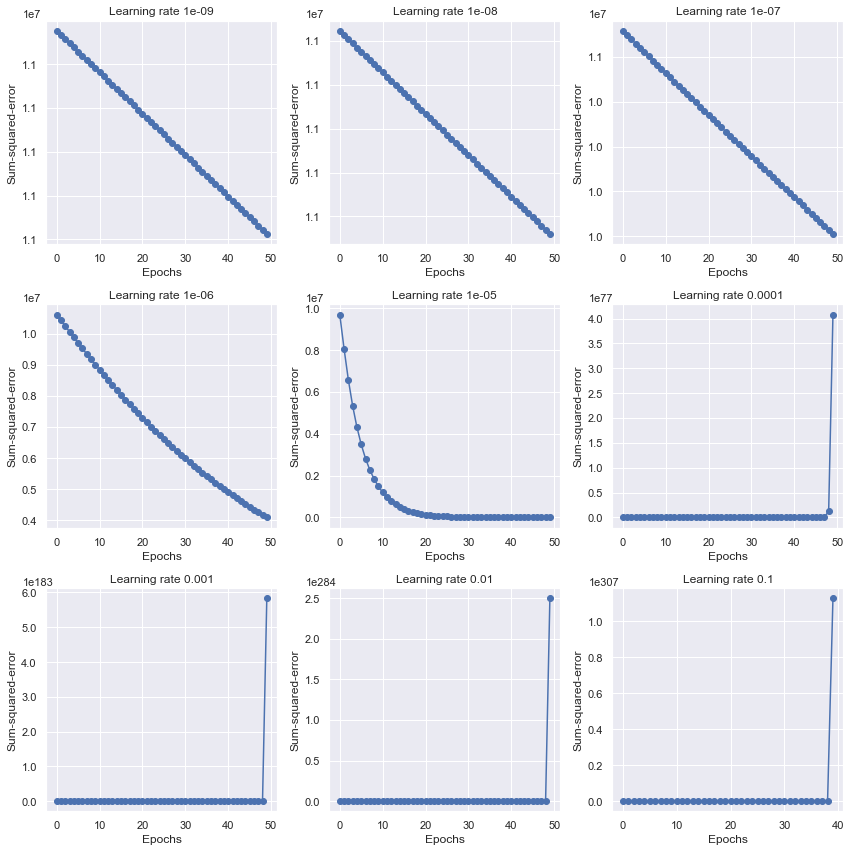

In [5]:
from matplotlib.ticker import ScalarFormatter
# Custom axis formatter
"""
ScalarFormatter does not currently support custom formats for the ticks, such as setting numbers of decimals. 
However you can extend the class, so to force it to use a format that you specify.
See https://stackoverflow.com/questions/42142144/displaying-first-decimal-digit-in-scientific-notation-in-matplotlib.
ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0)) This for sci notation do not allow format the number of digits.
"""


class ScalarFormatterForceFormat(ScalarFormatter):
    def _set_format(self):  # Override function that finds format to use.
        self.format = "%1.1f"  # Give format here


learning_rates = [np.round(lr * 1e-9, decimals=9) for lr in 10**np.arange(9)]
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
n_epochs = 50

for learning_rate, ax in zip(learning_rates, axes.ravel()):
    ada = Adaline(n_epochs=n_epochs,
                  learning_rate=learning_rate).fit(X_train_scaled, y_train)
    ax.plot(np.arange(n_epochs), ada.cost, marker='o')
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Sum-squared-error")
    ax.set_title("Learning rate {}".format(learning_rate))
    yfmt = ScalarFormatterForceFormat()
    yfmt.set_powerlimits((0, 0))
    ax.yaxis.set_major_formatter(yfmt)
    ax.get_yaxis().get_offset_text().set_position((-0.1, 0))
plt.tight_layout()

# Confusion matrix

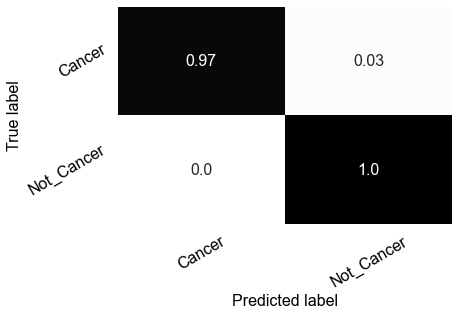

In [6]:
ada = Adaline(n_epochs=n_epochs,
              learning_rate=1e-5).fit(X_train_scaled, y_train)
y_pred = ada.predict(X_test_scaled)
fig, ax = plt.subplots(1, 1)
cm = sklearn.metrics.confusion_matrix(y_test, ada.predict(X_test_scaled))
plot_confusion_matrix(cm, ax, ["Cancer", "Not_Cancer"], normalize=True)